In [3]:
%matplotlib inline

import sys
import scipy
import scipy.stats as ss
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random

In [4]:
ct_test = pd.read_csv('OnlineRetail4.csv') 
print(ct_test.shape)
ct_test.head()

(10050, 11)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsPromotion,Sex,Region
0,370859,44142.0,Remain,3,31/08/2023 13:21,28.08,95496,Australia,No,Female,South
1,455672,37036.0,Officer,19,18/11/2023 21:10,38.73,56057,Australia,Yes,Female,South
2,824795,69973.0,Program,11,03/07/2023 06:52,20.50,55855,Australia,No,Female,East
3,490051,96135.0,Simple,10,06/12/2023 10:04,46.28,34631,Canada,Yes,Female,South
4,549040,24211.0,Particularly,10,23/02/2024 15:18,7.54,46774,United Kingdom,Yes,Female,West


In [5]:
mean_rate = ct_test['InvoiceNo'].mean()


# ddof is the degrees of freedom correction 
# in the calculation of the standard deviation;
# for population standard deviation ddof=0
stdev_rate = ct_test['InvoiceNo'].std(ddof=0)


In [6]:
print('Mean participation rate is {:.3f}'.format(mean_rate))
print('Standard deviation is {:.3f}'.format(stdev_rate))

Mean participation rate is 498198.748
Standard deviation is 285918.634


In [7]:
zscore_rate = ss.zscore(ct_test['InvoiceNo'], ddof=0)
ct_test = ct_test.assign(zscore=zscore_rate)
ct_test.head(8)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsPromotion,Sex,Region,zscore
0,370859,44142.0,Remain,3,31/08/2023 13:21,28.08,95496,Australia,No,Female,South,-0.445371
1,455672,37036.0,Officer,19,18/11/2023 21:10,38.73,56057,Australia,Yes,Female,South,-0.148737
2,824795,69973.0,Program,11,03/07/2023 06:52,20.50,55855,Australia,No,Female,East,1.142270
3,490051,96135.0,Simple,10,06/12/2023 10:04,46.28,34631,Canada,Yes,Female,South,-0.028497
4,549040,24211.0,Particularly,10,23/02/2024 15:18,7.54,46774,United Kingdom,Yes,Female,West,0.177817
5,697534,21136.0,Send,7,01/04/2023 21:39,13.34,36631,Canada,No,Male,South,0.697175
6,307304,31789.0,Better,1,18/03/2024 09:56,30.23,56881,France,No,Female,South,-0.667654
7,88406,59412.0,Natural,2,03/03/2024 19:02,12.27,32500,France,No,Female,West,-1.433250


In [8]:
def plot_anomaly(score_data, threshold):
    # Mask to plot values above and below threshold in different colors
    score_data = score_data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(score_data), len(score_data))
    mask_outlier = (score_data < threshold)
    
    
    plt.figure(dpi=150)
    plt.plot(ranks[~mask_outlier], score_data[~mask_outlier],'o', color='b',label='Retails')
    plt.plot(ranks[mask_outlier], score_data[mask_outlier],'o', color='r', label='anomalies')
    plt.axhline(threshold,color='r',label='threshold', alpha=0.5)
    plt.legend(loc = 'lower left')
    plt.title('Z-score vs. Retails', fontweight='bold')
    plt.xlabel('UnitPrice')
    plt.ylabel('Z-score')
    plt.show()

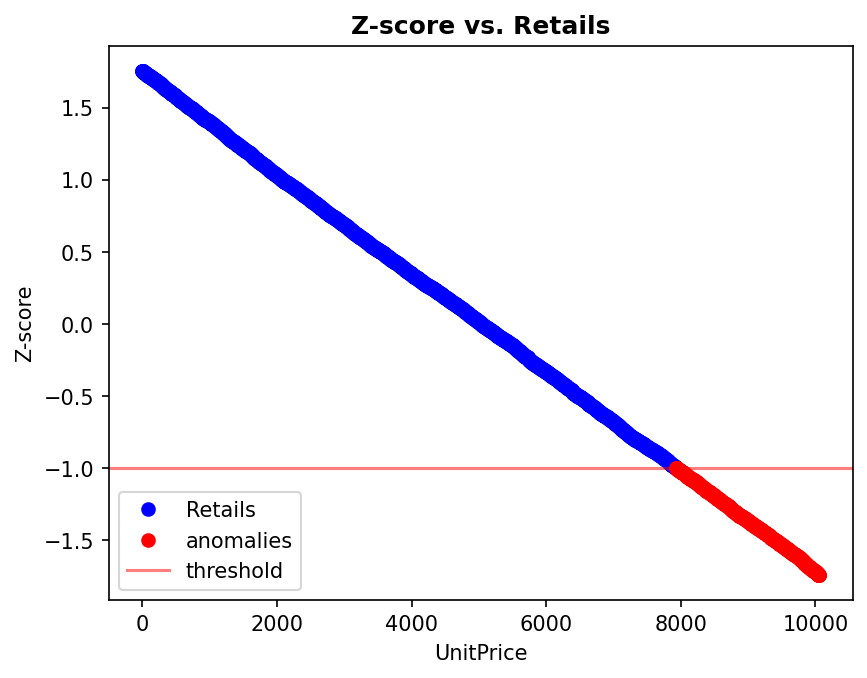

In [9]:
plot_anomaly(ct_test['zscore'], -1)

In [10]:
zscore_anomalies = ct_test[(ct_test['zscore'] < -2)]
zscore_anomalies

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsPromotion,Sex,Region,zscore


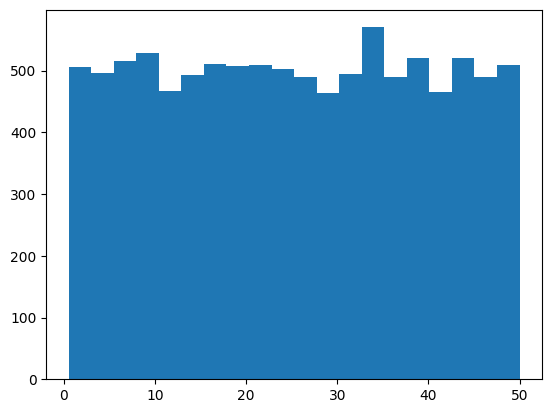

In [11]:
nbins= 20
n_hist, bins_hist, patches_hist = plt.hist(ct_test['UnitPrice'], nbins, density=False,
                           cumulative=False, linewidth=2.0, label='data')

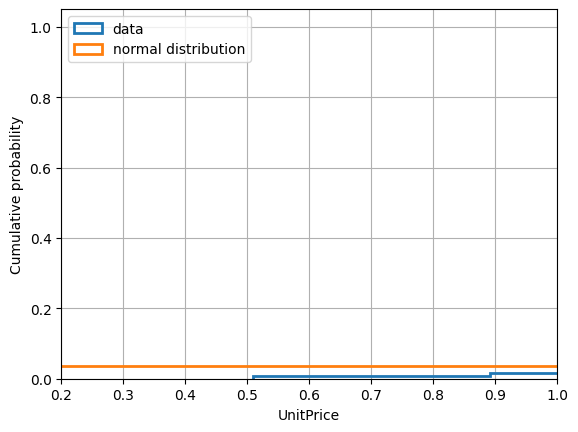

In [12]:
num_bins = 130
normal_dist = [random.gauss(mean_rate, stdev_rate) for _ in range(500)]
n, bins, patches = plt.hist(ct_test['UnitPrice'], num_bins, density=True, histtype='step',
                           cumulative=True, linewidth=2.0, label='data')
plt.hist(normal_dist, num_bins, density=True, histtype='step',
                           cumulative=True, linewidth=2.0, label='normal distribution')
plt.grid(True)
plt.legend(loc='upper left')
axes = plt.gca()
axes.set_xlim([0.2,1.0])
plt.xlabel('UnitPrice')
plt.ylabel('Cumulative probability')
plt.show()

In [13]:
def modified_zscore(data, consistency_correction=1.4826):
    """
    Returns the modified z score and Median Absolute Deviation (MAD) from the scores in data.
    The consistency_correction factor converts the MAD to the standard deviation for a given
    distribution. The default value (1.4826) is the conversion factor if the underlying data
    is normally distributed
    """
    median = np.median(data)
    
    deviation_from_med = np.array(data) - median

    mad = np.median(np.abs(deviation_from_med))
    mod_zscore = deviation_from_med/(consistency_correction*mad)
    return mod_zscore, mad

In [14]:
mad_zscore, mad_unitprice = modified_zscore(ct_test['UnitPrice'])
z_sc_unitprice = ct_test.assign(zscore_median=mad_zscore)

In [15]:
mod_zscore_anomalies = z_sc_unitprice[(z_sc_unitprice['zscore_median'] < -2)]
mod_zscore_anomalies

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsPromotion,Sex,Region,zscore,zscore_median


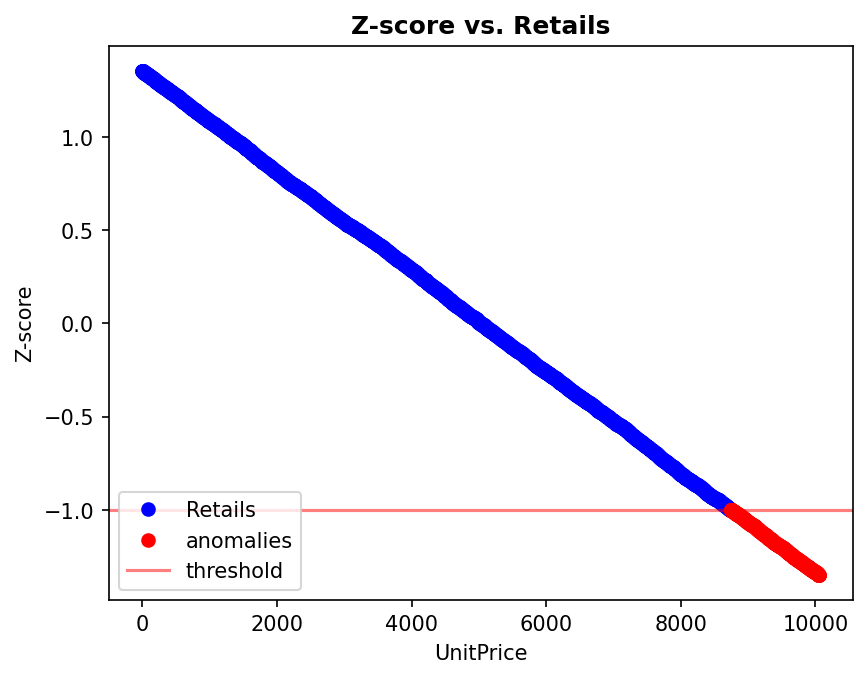

In [16]:

plot_anomaly(z_sc_unitprice['zscore_median'], -1)


In [17]:
z_sc_unitprice['zscore_median'].describe()

count    1.005000e+04
mean     2.467081e-03
std      7.811293e-01
min     -1.349255e+00
25%     -6.732614e-01
50%      9.703609e-17
75%      6.755835e-01
max      1.354718e+00
Name: zscore_median, dtype: float64

In [18]:
z_sc_unitprice['zscore'].describe()

count    1.005000e+04
mean     9.403202e-17
std      1.000050e+00
min     -1.741914e+00
25%     -8.659929e-01
50%      4.516152e-03
75%      8.531929e-01
max      1.754671e+00
Name: zscore, dtype: float64

Q2----------------------------->


In [19]:
top_price = pd.read_csv('OnlineRetail5.csv', 
                        encoding='utf-8',  
                        names=['Year', 'Customer name', 'ProductID', 'Price'], skiprows=1)                                                                                
top_price

,Year,Customer name,ProductID,Price
0,2016,Richard Williams,6880,294.40
1,2018,James Walker,4850,921.63
2,2013,Sandra Perez,9419,940.06
3,2016,Sharon Ayers,1573,656.43
4,2015,Steve Meadows,9563,640.09
5,2019,Melanie Pineda,1762,23.35
6,2013,Jillian Berry,4105,615.71
7,2016,Jacqueline Lawson,2695,176.75
8,2020,Benjamin Jackson,8134,28.36
9,2018,Sara Gutierrez,3003,144.94


In [20]:
mean_price = top_price['Price'].mean()
stdev_price = top_price['Price'].std(ddof=0)
print('Mean number of Price is {:.2f}'.format(mean_price))
print('Standard deviation is {:.2f}'.format(stdev_price))

Mean number of Price is 454.31
Standard deviation is 311.44


In [21]:
zscore_price = ss.zscore(top_price['Price'], ddof=0)
top_price = top_price.assign(zscore=zscore_price)
top_price.head(21)

,Year,Customer name,ProductID,Price,zscore
0,2016,Richard Williams,6880,294.40,-0.513455
1,2018,James Walker,4850,921.63,1.500500
2,2013,Sandra Perez,9419,940.06,1.559676
3,2016,Sharon Ayers,1573,656.43,0.648977
4,2015,Steve Meadows,9563,640.09,0.596511
5,2019,Melanie Pineda,1762,23.35,-1.383762
6,2013,Jillian Berry,4105,615.71,0.518230
7,2016,Jacqueline Lawson,2695,176.75,-0.891215
8,2020,Benjamin Jackson,8134,28.36,-1.367676
9,2018,Sara Gutierrez,3003,144.94,-0.993352


In [22]:
def plot_anomaly_price(price_data, threshold):
    price_data = price_data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(price_data), len(price_data))
    mask_outlier = (price_data > threshold)
    
    plt.figure(dpi=150)
    plt.plot(ranks[mask_outlier], price_data[mask_outlier], 'o', color='r', label='anomalies')
    plt.plot(ranks[~mask_outlier], price_data[~mask_outlier], 'o', color='b', label='typical customer')
    plt.axhline(threshold,color='r', label='threshold', alpha=0.5)
    plt.legend(loc='upper right')
    plt.title('Z-score vs. customer', fontweight='bold')
    plt.xticks(np.arange(0, 40, step=10.0))
    plt.xlabel('Customer Rank')
    plt.ylabel('Z-score')
    plt.show()

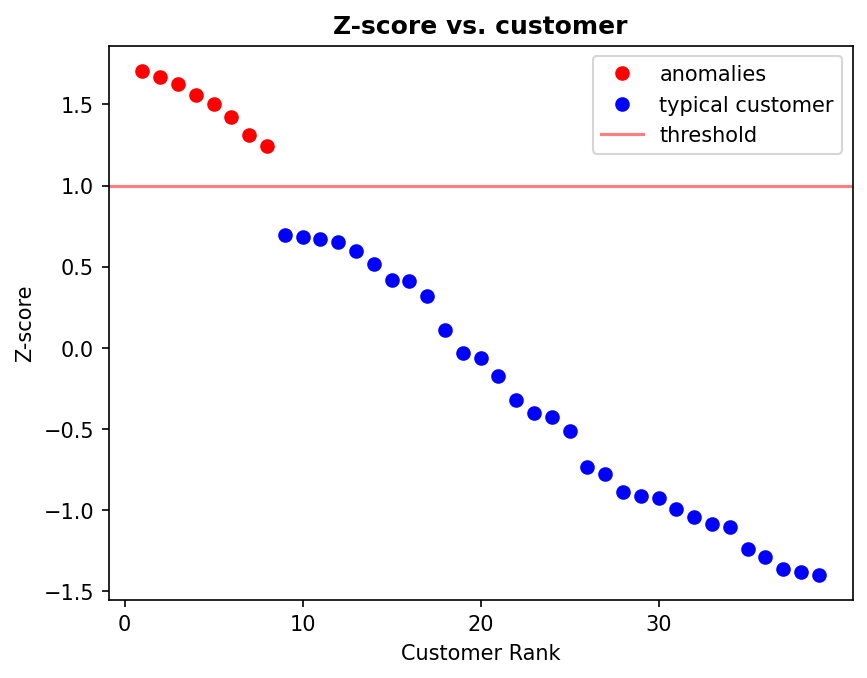

In [23]:
plot_anomaly_price(top_price['zscore'], 1)

In [24]:
zscore_anomalies_customers = top_price[(top_price['zscore'] > 1)]
zscore_anomalies_customers

,Year,Customer name,ProductID,Price,zscore
1,2018,James Walker,4850,921.63,1.500500
2,2013,Sandra Perez,9419,940.06,1.559676
13,2023,Ryan Ewing,9582,973.93,1.668428
15,2020,Stacy Miller,6658,841.24,1.242378
18,2020,Melissa Moore,6473,960.11,1.624054
19,2014,Holly Johnson,5395,896.51,1.419843
27,2018,Gary Lawson,5453,862.75,1.311444
29,2014,Fred Johns,7609,986.04,1.707312


In [25]:
median_price = np.median(top_price['Price'])
median_price

434.94

In [26]:
mod_zscore_price, mad_price = modified_zscore(top_price['Price'])
top_price = top_price.assign(mod_zscore=mod_zscore_price)

In [27]:
def plot_anomaly_price_2(price_data, threshold):
    price_data = price_data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(price_data), len(price_data))
    mask_outliers = (price_data > threshold)
    
    plt.figure(dpi=150)
    plt.plot(ranks[mask_outliers], price_data[mask_outliers],'o', color='r',label='anomalies')
    plt.plot(ranks[~mask_outliers], price_data[~mask_outliers],'o', color='b', label='typical customer')
    plt.axhline(threshold,color='r',label='threshold', alpha=0.5)
    plt.legend(loc = 'upper right')
    plt.title('Modified z-score vs. customer', fontweight='bold')
    plt.xticks(np.arange(0, 40, step=2.0))
    plt.xlabel('customer')
    plt.ylabel('Modified z-score')
    plt.show()

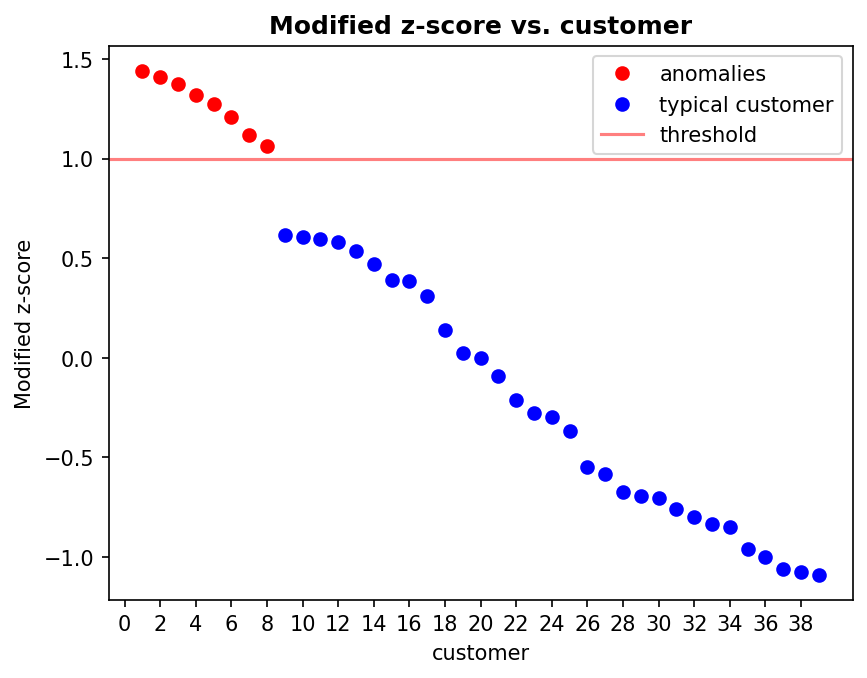

In [28]:
plot_anomaly_price_2(top_price['mod_zscore'], 1)

In [29]:
mod_zscore_anomalies_customers = top_price[(top_price['mod_zscore'] > 1)]
mod_zscore_anomalies_customers

,Year,Customer name,ProductID,Price,zscore,mod_zscore
1,2018,James Walker,4850,921.63,1.500500,1.271420
2,2013,Sandra Perez,9419,940.06,1.559676,1.319566
13,2023,Ryan Ewing,9582,973.93,1.668428,1.408047
15,2020,Stacy Miller,6658,841.24,1.242378,1.061411
18,2020,Melissa Moore,6473,960.11,1.624054,1.371944
19,2014,Holly Johnson,5395,896.51,1.419843,1.205797
27,2018,Gary Lawson,5453,862.75,1.311444,1.117603
29,2014,Fred Johns,7609,986.04,1.707312,1.439683


In [30]:
print('The value of MAD is {:.2f}'.format(mad_price))

The value of MAD is 258.19
